In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.metrics import mean_absolute_error, r2_score, explained_variance_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from xgboost import XGBRegressor

#**Preprocessing**

In [ ]:
df = pd.read_csv("aryl_amination_subset5.csv", index_col = 'Pd(0)-ligand_file_name')
df = df.drop('entry', axis=1)
df.head()

,aryl_halide_file_name,aryl_halide_SMILES,aryl_halide_stoichiometry,aryl_halide_number_of_atoms,aryl_halide_charge,aryl_halide_multiplicity,aryl_halide_convergence_criteria,aryl_halide_dipole,aryl_halide_molar_mass,aryl_halide_molar_volume,...,Pd(0)-ligand_vib_42_standard_E-M_angle,Pd(0)-ligand_atom1_%VBur,Pd(0)-ligand_atom2_%VBur,Pd(0)-ligand_atom3_%VBur,Pd(0)-ligand_atom4_%VBur,Pd(0)-ligand_c_min_%VBur,Pd(0)-ligand_c_min+1_%VBur,Pd(0)-ligand_c_max_%VBur,Pd(0)-ligand_c_max-1_%VBur,yield
Pd(0)-ligand_file_name,,,,,,,,,,,,,,,,,,,,,
Pd0-X-Phos,3-chloropyridine,Clc1cccnc1,C5H4ClN,11,0,1,met,2.0883,113.5463,987.175,...,84.6033,0.887309,0.843957,0.819377,0.826712,0.545074,0.550493,0.887309,0.534056,7.787908
Pd0-X-Phos,3-chloropyridine,Clc1cccnc1,C5H4ClN,11,0,1,met,2.0883,113.5463,987.175,...,84.6033,0.887309,0.843957,0.819377,0.826712,0.545074,0.550493,0.887309,0.534056,4.169293
Pd0-X-Phos,3-chloropyridine,Clc1cccnc1,C5H4ClN,11,0,1,met,2.0883,113.5463,987.175,...,84.6033,0.887309,0.843957,0.819377,0.826712,0.545074,0.550493,0.887309,0.534056,6.351542
Pd0-X-Phos,3-chloropyridine,Clc1cccnc1,C5H4ClN,11,0,1,met,2.0883,113.5463,987.175,...,84.6033,0.887309,0.843957,0.819377,0.826712,0.545074,0.550493,0.887309,0.534056,3.963450
Pd0-X-Phos,3-chloropyridine,Clc1cccnc1,C5H4ClN,11,0,1,met,2.0883,113.5463,987.175,...,84.6033,0.887309,0.843957,0.819377,0.826712,0.545074,0.550493,0.887309,0.534056,2.014672


In [ ]:
df = df.select_dtypes(exclude='object')     #Removing non-numeric columns

In [ ]:
scaler = MinMaxScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

In [ ]:
X = df.loc[:, df.columns != 'yield']   #Predictor variables
y = df['yield']                        #Target variable (yield)

In [ ]:
print(f"Number of features: {X.shape[1]}")
print(f"Number of samples: {X.shape[0]}")

Number of features: 1644
Number of samples: 791


#**Dimensionality Reduction**

In [ ]:
zero_var = X.std()[X.std() == 0].index            #Removing columns with zero variance
X = X[X.columns.difference(zero_var)]

In [ ]:
print(f"Number of features: {X.shape[1]}")

Number of features: 1151


In [ ]:
def duplicates_removal(X, round=None):
    X_copy = X.copy()
    if round is not None:
        scaler = MinMaxScaler()
        X_copy = pd.DataFrame(scaler.fit_transform(X_copy),
                          columns=X_copy.columns,
                          index=X_copy.index)
        X_copy = X_copy.round(round)
    dup_cols = X_copy.columns[X_copy.T.duplicated()].tolist()

    X = X[X.columns.difference(dup_cols)]
    return X

In [ ]:
X = duplicates_removal(X, round=3)     #Removing duplicate columns

In [ ]:
print(f"Number of features: {X.shape[1]}")

Number of features: 960


In [ ]:
def correlated_removal(X, thresh=0.95):
    X_copy = X.copy()
    N = X_copy.shape[1]
    corr_coeff = X_copy.corr().abs()

    to_drop = set()
    for i in range(N-1):
        for j in range(i+1, N):
            if corr_coeff.iloc[i][j] > thresh and i not in to_drop:
                to_drop.add(j)

    corr_cols = [X_copy.columns[i] for i in to_drop]

    X = X[X.columns.difference(corr_cols)]
    return X

In [ ]:
X = correlated_removal(X, thresh=0.99)        #Removing highly correlated columns

In [ ]:
print(f"Number of features: {X.shape[1]}")

Number of features: 285


##**PCA**

In [ ]:
X_reduced = X.copy(deep=True)

In [ ]:
pca = PCA()
X_pca = pca.fit_transform(X_reduced)

In [ ]:
features_loadings = pd.DataFrame(pca.components_)
features_loadings.head()

,0,1,2,3,4,5,6,7,8,9,...,275,276,277,278,279,280,281,282,283,284
0,-0.128384,0.114401,0.088281,-0.165722,0.165710,-0.130240,-0.091898,0.150748,0.141314,0.112489,...,0.000149,0.000196,0.000065,0.000011,0.000128,-0.000215,-0.000160,-0.000090,-0.000165,-0.000181
1,0.073967,0.022323,-0.084399,-0.017505,0.055128,-0.071448,-0.109238,-0.027263,0.034094,-0.045355,...,0.000391,0.000515,0.000166,0.000032,0.000331,-0.000562,-0.000416,-0.000238,-0.000434,-0.000474
2,-0.010103,-0.111661,-0.128445,0.071293,-0.010035,-0.055871,-0.116030,-0.017851,0.040062,-0.129081,...,-0.000401,-0.000522,-0.000159,-0.000040,-0.000328,0.000568,0.000416,0.000249,0.000443,0.000482
3,0.000086,0.000419,0.000232,-0.000337,0.000250,-0.000084,0.000026,0.000096,0.000059,0.000328,...,0.000579,0.000728,0.000179,0.000095,0.000417,-0.000785,-0.000549,-0.000381,-0.000631,-0.000679
4,-0.000007,-0.000032,-0.000015,0.000027,-0.000022,0.000010,0.000002,-0.000008,-0.000007,-0.000024,...,-0.000158,-0.000180,-0.000014,-0.000051,-0.000075,0.000189,0.000114,0.000119,0.000166,0.000173


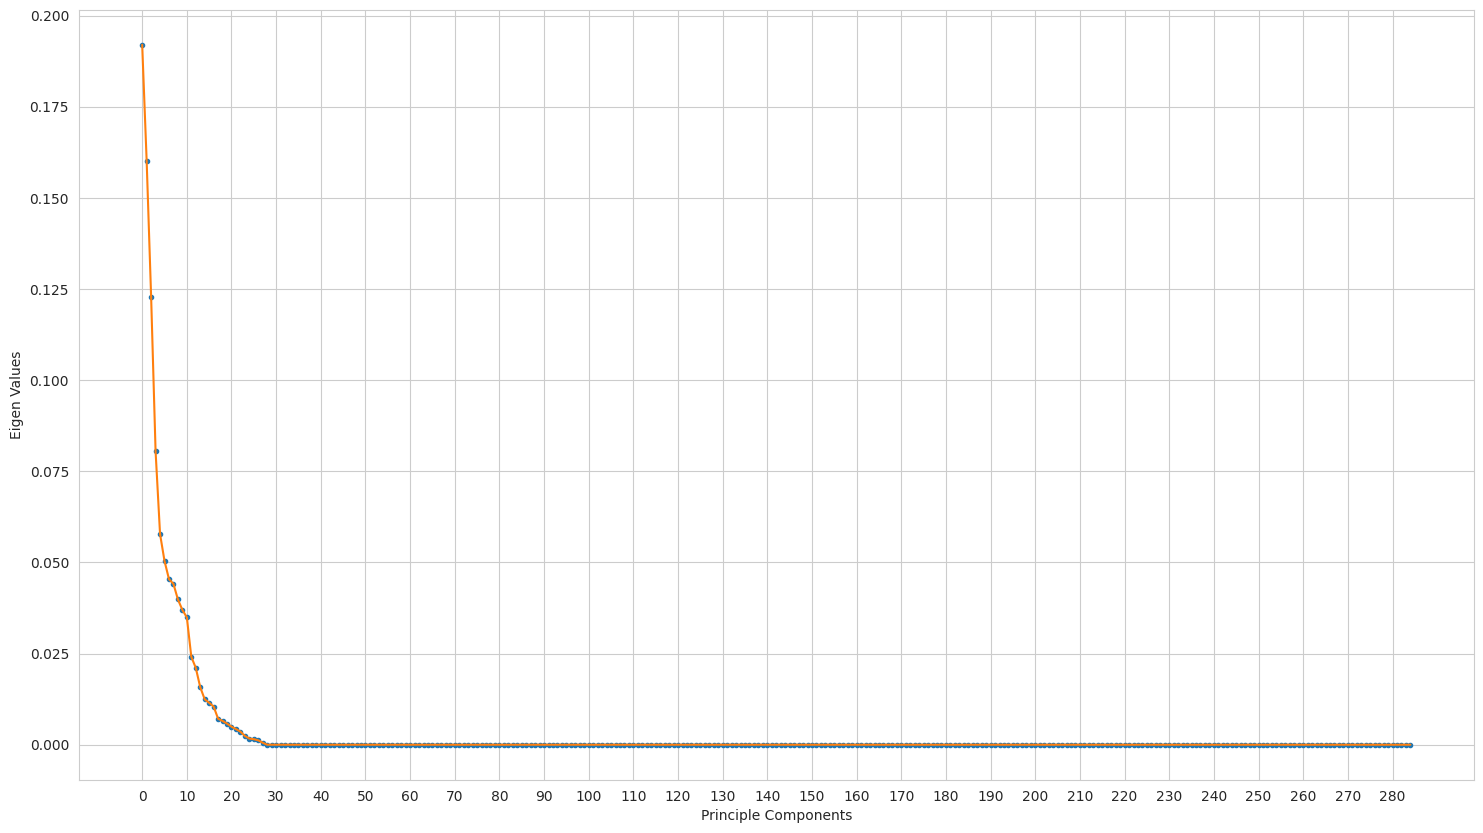

In [ ]:
sns.set_style(style='whitegrid', rc=None)

plt.figure(figsize=(18 , 10))

plt.plot(pca.explained_variance_ratio_,'.')
plt.plot(pca.explained_variance_ratio_)
plt.xticks(range(0,285,10))
plt.xlabel('Principle Components')
plt.ylabel('Eigen Values')
plt.show()

In [ ]:
cov_matrix = np.cov(X_pca.T)

eig_vals, eig_vecs = np.linalg.eig(cov_matrix)

eigen_pairs = [(np.abs(eig_vals[i]), eig_vecs[ :, i]) for i in range(len(eig_vals))]

tot = sum(eig_vals)
var_exp = [( i /tot ) * 100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

/usr/local/lib/python3.10/dist-packages/matplotlib/transforms.py:762: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)
/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


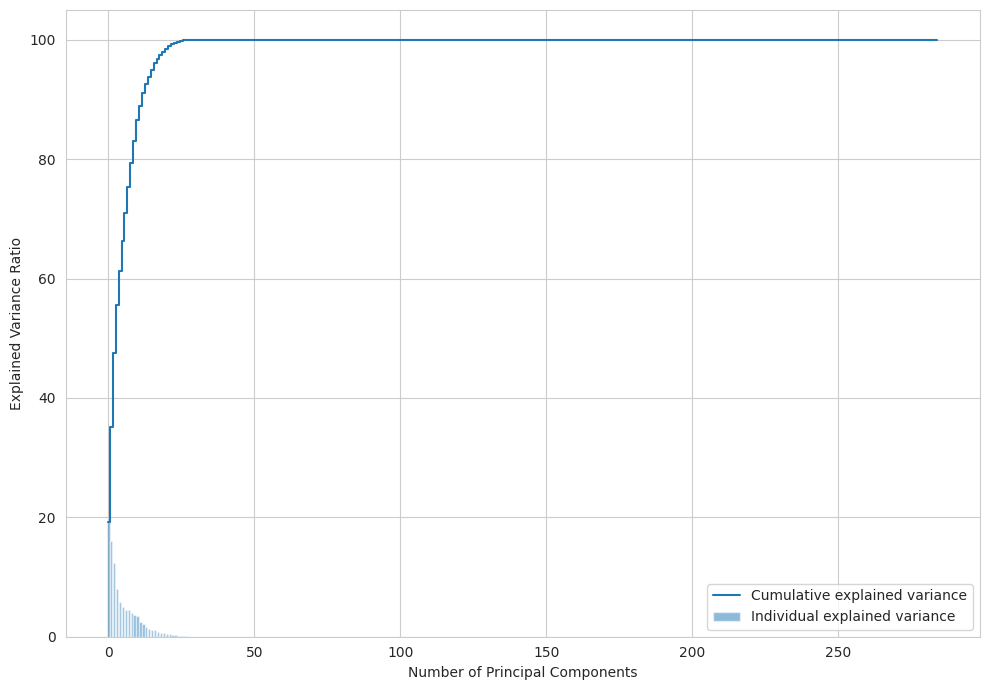

In [ ]:
plt.figure(figsize=(10, 7))
plt.bar(range(285), var_exp, alpha = 0.5, align = 'center', label = 'Individual explained variance')
plt.step(range(285), cum_var_exp, where='mid', label = 'Cumulative explained variance')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Number of Principal Components')
plt.legend(loc = 'best')
plt.tight_layout()
plt.show()

First 20 principal components explain 98% of the variance

In [ ]:
X_pca = X_pca[:, :20]

#**Models**

In [ ]:
ligands = df.index.unique()
ligands.tolist()

['Pd0-X-Phos', 'Pd0-t-Bu-X-Phos', 'Pd0-t-Bu-BrettPhos', 'Pd0-Ad-BrettPhos']

In [ ]:
#Splitting the dataset into train and test datasets

X_train = X.loc[ligands[:3]].values
y_train = y.loc[ligands[:3]].values

X_test = X.loc[ligands[3:]].values
y_test = y.loc[ligands[3:]].values

##**Linear Regression**

In [ ]:
LR = LinearRegression(fit_intercept=True).fit(X_train, y_train)
y_pred = LR.predict(X_test)

print (f" R2: {round(r2_score(y_test, y_pred), 4)}, MAE: {round(mean_absolute_error(y_test, y_pred), 4)}")

 R2: -9.893587248649049e+25, MAE: 3146658519575.0796


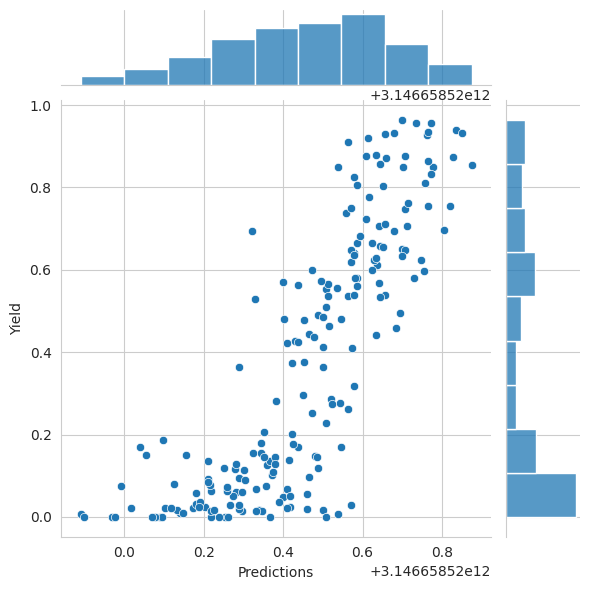

In [ ]:
data = pd.concat([pd.Series(y_pred), pd.Series(y_test)], axis=1)
data.columns=['Predictions', 'Yield']

g = sns.jointplot(x='Predictions', y='Yield', data=data)

##**Lasso Regression**

In [ ]:
model = LassoCV(cv=5).fit(X_train, y_train)
y_pred = model.predict(X_test)

In [ ]:
print (f" R2: {round(r2_score(y_test, y_pred), 4)}, MAE: {round(mean_absolute_error(y_test, y_pred), 4)}")

data = pd.concat([pd.Series(y_pred), pd.Series(y_test)], axis=1)
data.columns=['Predictions', 'Yield']

 R2: 0.5936, MAE: 0.1653


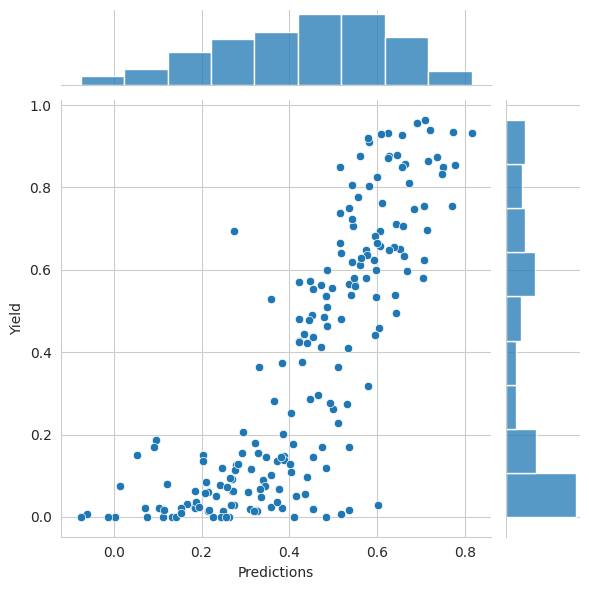

In [ ]:
g = sns.jointplot(x='Predictions', y='Yield', data=data)

##**Random Forest**


In [ ]:
RF = RandomForestRegressor(n_estimators=50, max_depth=35, min_samples_leaf=1, min_samples_split=4, random_state = 3)
RF.fit(X_train, y_train)

RandomForestRegressor(max_depth=35, min_samples_split=4, n_estimators=50,
                      random_state=3)

In [ ]:
y_pred = RF.predict(X_test)
print (f" R2: {round(r2_score(y_test, y_pred), 4)}, MAE: {round(mean_absolute_error(y_test, y_pred), 4)}")

 R2: 0.8543, MAE: 0.0946


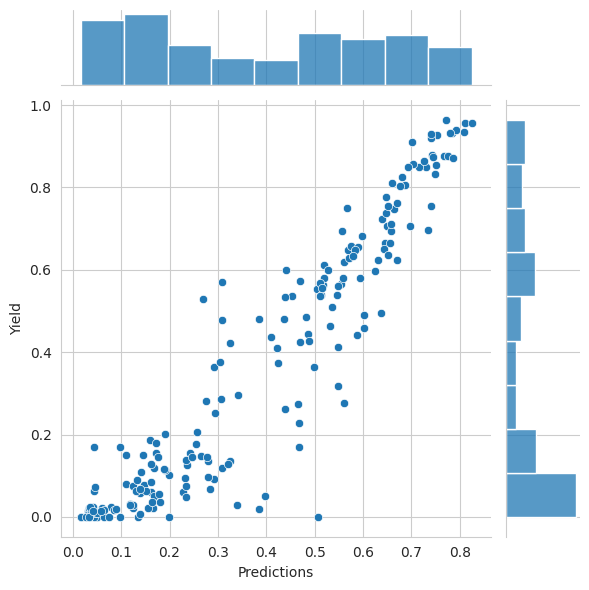

In [ ]:
data=pd.concat([pd.Series(y_pred), pd.Series(y_test)], axis=1)
data.columns=['Predictions', 'Yield']

g = sns.jointplot(x='Predictions', y='Yield', data=data)

**Hyperparameter tuning**

In [ ]:
#def objective(trial):
#    list_trees = [50, 80, 100, 150, 180, 200, 250, 300, 400, 500]
#    depth = [1, 2, 3, 4, 10, 15, 18, 20, 22, 25, 28 , 30, 35, 40, 45, 50, 75, 100]
#    param = {
#        'n_estimators' : trial.suggest_categorical('n_estimators', list_trees),
#        'max_depth' : trial.suggest_categorical('max_depth', depth),
#        'min_samples_leaf': trial.suggest_categorical('min_samples_leaf', [1,2,3]),
#        'min_samples_split': trial.suggest_categorical('min_samples_split', [2, 4, 6, 8]),
#            }
#    clf = RandomForestRegressor(**param)
#    clf.fit(X_train, y_train)
#    return mean_absolute_error(y_test, clf.predict(X_test))

In [ ]:
# Running parameter search
#study = optuna.create_study(direction='minimize')
#study.optimize(objective, n_trials=25)

##**XG Boosting**

In [ ]:
XGBR = XGBRegressor(n_estimators= 750, max_depth= 9, learning_rate= 0.009481614274337328, subsample= 1.0, colsample_bylevel= 0.4, reg_alpha= 0.01803772093358306, reg_lambda= 0.0031305258431227716)

In [ ]:
XGBR.fit(X_train, y_train)
y_pred = XGBR.predict(X_test)
print (f" R2: {round(r2_score(y_test, y_pred), 4)}, MAE: {round(mean_absolute_error(y_test, y_pred), 4)}")

 R2: 0.8654, MAE: 0.0876


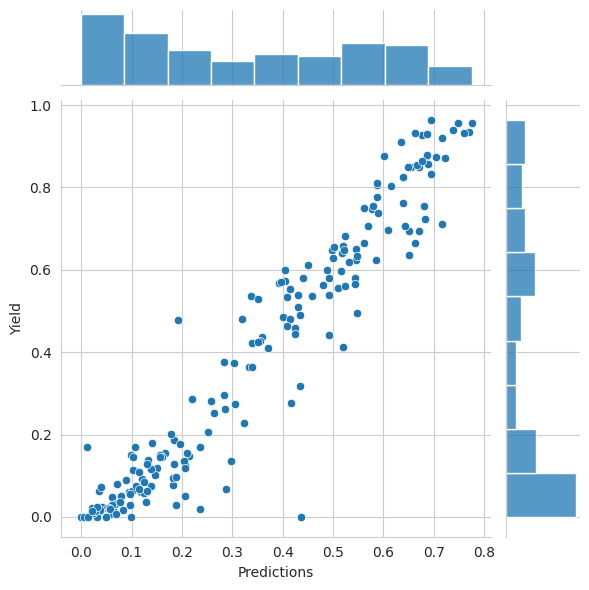

In [ ]:
data=pd.concat([pd.Series(y_pred), pd.Series(y_test)], axis=1)
data.columns=['Predictions', 'Yield']

g = sns.jointplot(x='Predictions', y='Yield', data=data)

**Hyperparameter tuning**

In [ ]:
#def objective_xgb(trial):
#   param = {
#        'n_estimators': trial.suggest_categorical('n_estimators', [50, 80, 100, 150, 180, 200, 250, 300, 400, 500, 750, 1000]),
#        'max_depth': trial.suggest_int('max_depth', 3, 11),
#        'learning_rate': trial.suggest_uniform('learning_rate', 0.005, 0.01),
#       'subsample': trial.suggest_categorical('subsample', [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]),
#        'colsample_bylevel': trial.suggest_categorical('colsample_bylevel', [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]),
#        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 100),
#        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 100),
#        'n_jobs': -1
#    }

#    XGBmod = XGBRegressor(**param)
#    XGBmod.fit(X_train, y_train)
#    return mean_absolute_error(y_test, XGBmod.predict(X_test))

In [ ]:
# Running parameter search
#study_XGB = optuna.create_study(direction='minimize')
#study_XGB.optimize(objective_xgb, n_trials=50)